In [27]:
from matplotlib import pyplot as plt
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('legend', fontsize=16) #fontsize of the legend

import numpy as np
from scipy.stats import expon
import pandas as pd
from tqdm import tqdm
from corner import corner

import sys

sys.path.insert(1,'../src')

from BayersianModel import BayersianModel
from Prior import Prior
from MCMC import NaiveSampler
from models import ChemicalReactionNetwork

from copy import deepcopy
from time import time

# Parameters

## the Gilespe simulation of hydrogens

- $k_1$: binding reaction rate
- $k_2$: breaking reaction rate
- $N_H$: number of $H$
- $N_{H_2}$: number of $H_2$
- $T$: total time of simulation

## parameters for inference

- n_observation
- k1_range
- k2_range
- box_size

In [2]:
k1 = 1
k2 = 2
theta = np.array([k1,k2])
NH = 10
NH2 = 10
X_init =  np.array([NH,NH2])
T = 20

reactions = [
    ({'H':2}, {'H2':1}),
    ({"H2":1},{"H":2})
]

chemicals = 'H H2'.split()

# here are some other parameters that is unrelevant to gilespe
n_observation = 1
k1_range = (.1,10)
k2_range = (.1,10)
parameter_range = np.array((k1_range,k2_range)).T
box_size = 0.12

In [3]:
def parameters2str(theta=theta,X_init=X_init,T=T):
    sep = ', '
    return '   k1 = ' + str(theta[0]) + sep + 'k2 = ' + str(theta[1]) + sep + '#H = ' + str(X_init[0]) + sep + '#H2 = ' + str(X_init[1]) + sep + 'T = ' + str(T) + ' '

In [4]:
Chemical_model = ChemicalReactionNetwork(
    theta,
    reactions,
    chemicals
)

In [5]:
x,r,t = Chemical_model.gilespie(X_init,T)

Text(0.5, 1.0, 'Gilespie Simulation for Hydrogen   k1 = 1, k2 = 2, #H = 10, #H2 = 10, T = 20 ')

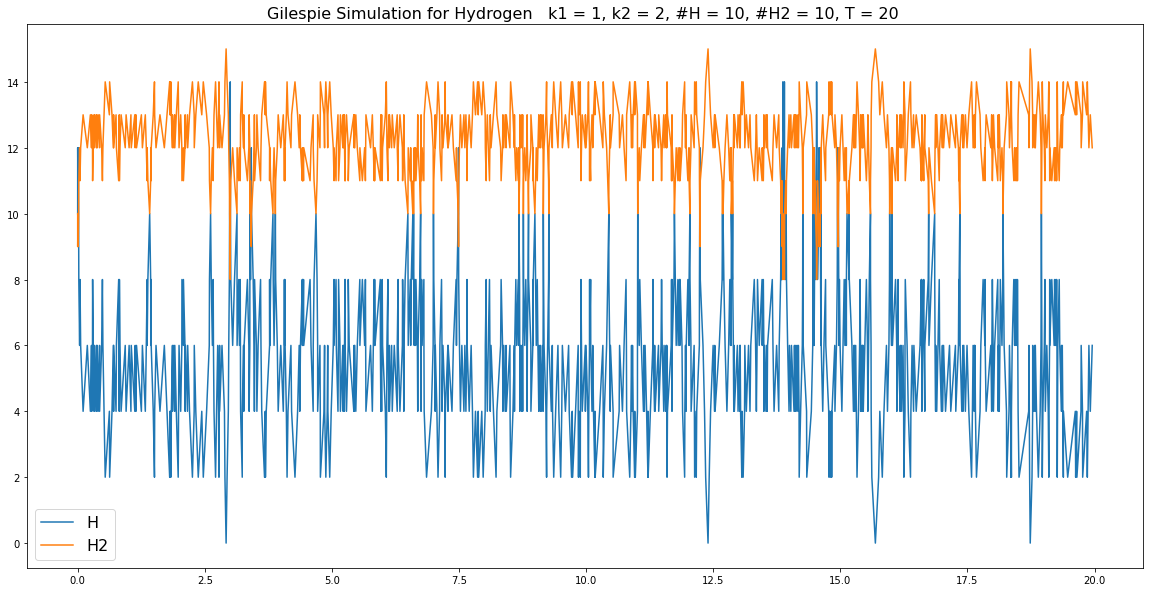

In [6]:
plt.figure(figsize=(20,10))
plt.plot(t,x[:,0],label='H')
plt.plot(t,x[:,1],label='H2')
plt.legend()
plt.title("Gilespie Simulation for Hydrogen" + parameters2str())

In [7]:
observation = [Chemical_model.gilespie(X_init,T) for _ in range(n_observation)]

In [8]:
prior = Prior(
    log_pdf = lambda _ : 0,
    sampler = lambda : (np.random.uniform(*parameter_range)),
    theta_range = parameter_range
)

In [9]:
def log_likelihood(theta,observation):
    theta = np.array(theta)
    return sum([Chemical_model.log_likelihood(
            theta,x,r,t,T) for x,r,t in observation])
    

In [10]:
model = BayersianModel(
    prior = prior,
    observation = observation,
    log_likelyhood = log_likelihood)

$k1 = 1,\ k2 = 2,\ \#H = 10,\ \#H2 = 10,\ T = 20$

computing posterior: 100%|██████████| 10000/10000 [03:54<00:00, 42.64it/s]


<AxesSubplot:title={'center':'the pdf for posterior'}>

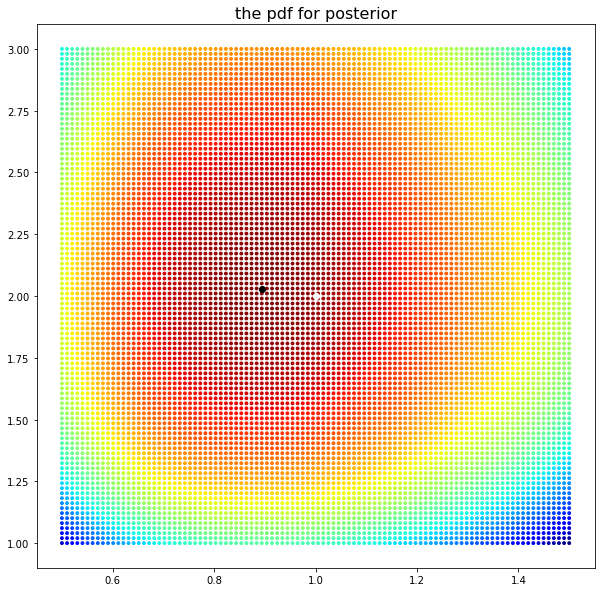

In [11]:
model.prior.theta_range = np.array([[0.5,1],[1.5,3]])
model.posterior_heatmap(true_theta=theta,n=(100,100),s=8)

$$
k_1(x)(x-1) = k_2(N-x)/2
$$

## inference

this inference is very slow because evaluating the log_posterior_proba is too expansive. 

In [12]:
mcmc = NaiveSampler(model=model)

init_pos = theta + np.random.uniform(-1,1,size=2)

posterior_samples = mcmc.simulation(theta_range='positive',box_size=box_size, n=int(1e5),init_position=init_pos)

sampling posterior: 100%|██████████| 100100/100100 [39:09<00:00, 42.61it/s]


acceptance rate: 0.41924075924075926


## plot

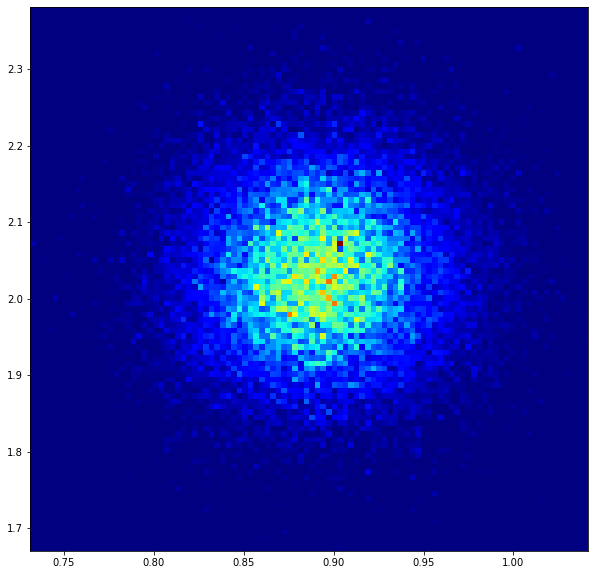

In [13]:
XX, YY = posterior_samples[1000:].T
plt.figure(figsize=(10,10))
ax = plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()

$k1 = 1,\ k2 = 2,\ \#H = 10,\ \#H2 = 10,\ T = 20$

In [14]:
from statsmodels.tsa.stattools import acf

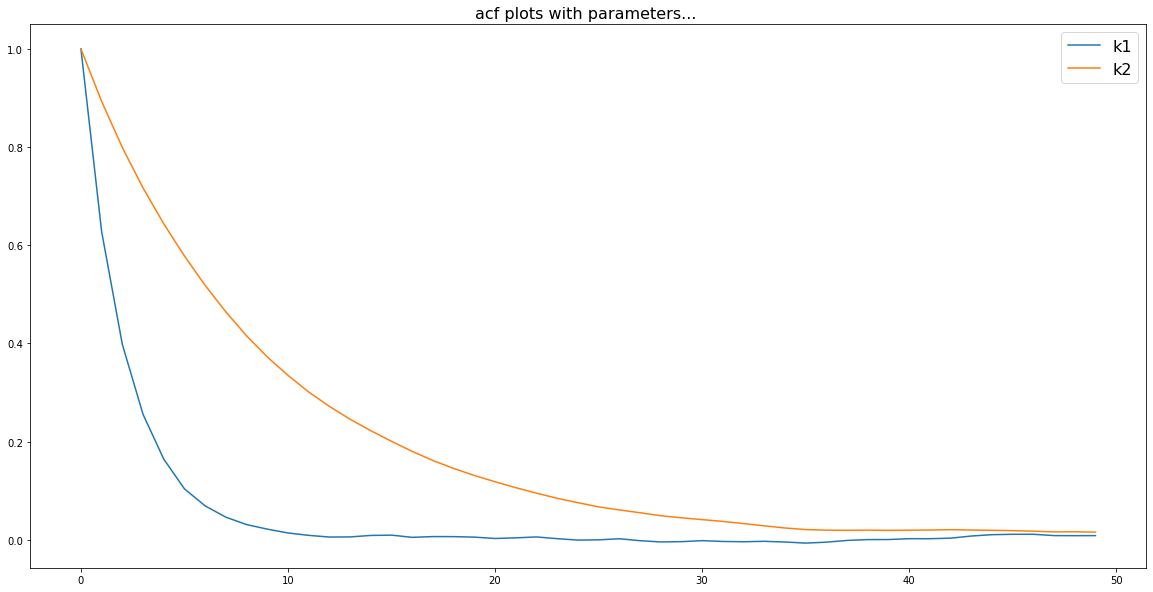

In [15]:
plt.figure(figsize=(20,10))
plt.plot(acf(XX,nlags=1000)[:50],label='k1')
plt.plot(acf(YY,nlags=1000)[:50],label='k2')
plt.title('acf plots with parameters... ')
plt.legend()

$\tau \le 20$, still not bad...  

In [17]:
from corner import corner

In [ ]:
figure = corner.corner(data, labels=[r"$x$", r"$y$", r"$\log \alpha$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})


## Corner plot

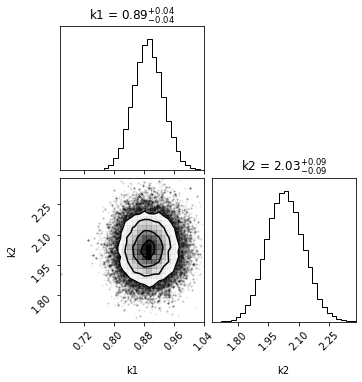

In [25]:
corner(
    posterior_samples,
    bins=30,
    labels=['k1','k2'],
    show_titles=True,
    title_kwargs={'fontsize':12},
    smooth=0.2
)
print()

In [30]:
mean_theta = np.cumsum(posterior_samples,axis=0)/np.arange(1,1+len(posterior_samples))[:,np.newaxis]

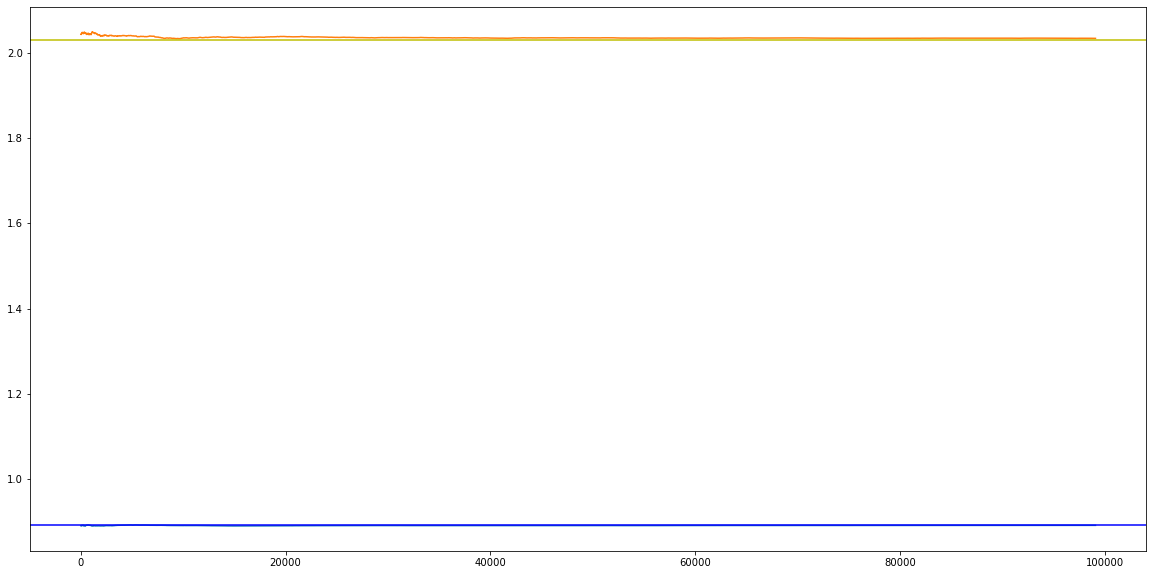

In [41]:
plt.figure(figsize=(20,10))
plt.plot(mean_theta[1000:])
plt.axhline(model.mpe_theta[0],c='b')
plt.axhline(model.mpe_theta[1],c='y')

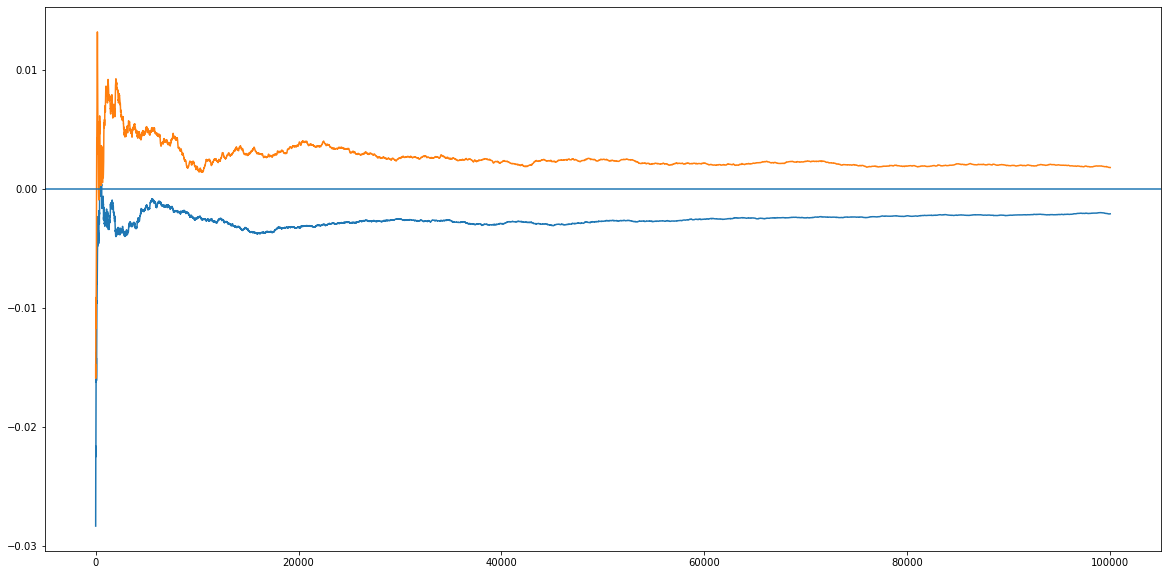

In [43]:
plt.figure(figsize=(20,10))
plt.plot((mean_theta[100:]-model.mpe_theta)/model.mpe_theta)
plt.axhline(0)

## Marginal plot



In [51]:
mask_xz = np.array([True,False,True])

In [108]:
df = pd.DataFrame(model.P.T,columns=['k1','k2','z'])
df['z'] = df['z'] - df['z'].mean()

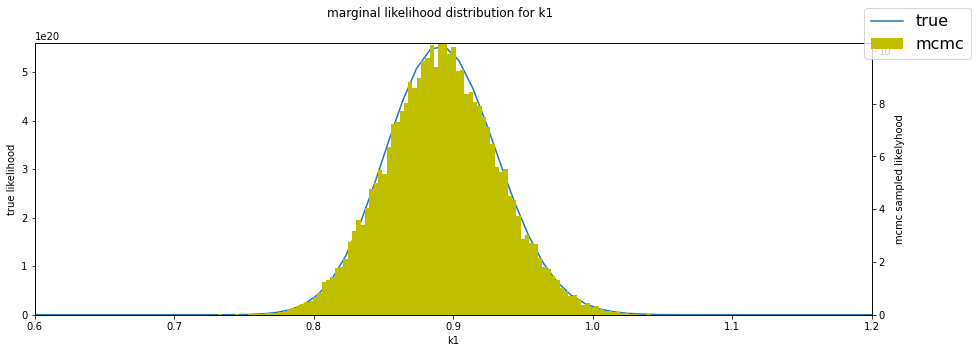

In [151]:
fig,ax1 = plt.subplots(figsize=(15,5))
fig.suptitle('marginal likelihood distribution for k1')

x = df.groupby(['k1']).mean().index
y = df.groupby(['k1']).mean()['exp z'].values
ax1.plot(x,y,label='true')
ax1.set_xlabel('k1')
ax1.set_ylabel('true likelihood')
ax1.set_ylim([0,5.6e20])


ax2 = ax1.twinx()
ax2.hist(XX,density=True,bins=100,color='y',label='mcmc')
ax2.set_ylabel('mcmc sampled likelyhood')
ax2.set_ylim([0,10.3])

ax1.set_xlim([0.6,1.2])

fig.legend()

plt.show()

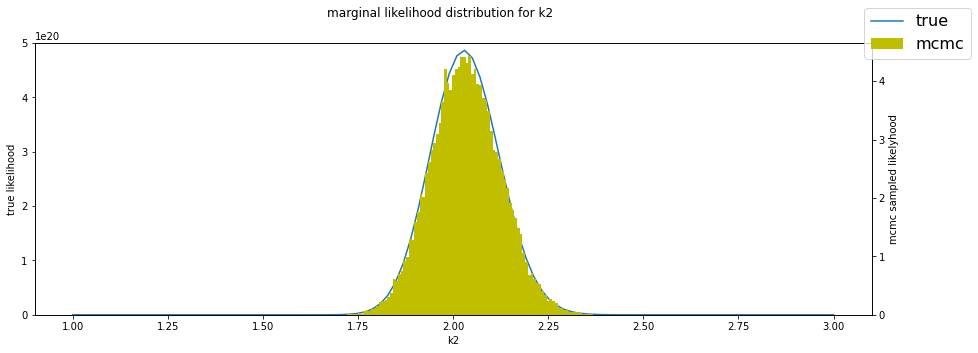

In [154]:
fig,ax1 = plt.subplots(figsize=(15,5))
fig.suptitle('marginal likelihood distribution for k2')

x = df.groupby(['k2']).mean().index
y = df.groupby(['k2']).mean()['exp z'].values
ax1.plot(x,y,label='true')
ax1.set_xlabel('k2')
ax1.set_ylabel('true likelihood')
ax1.set_ylim([0,5e20])

ax2 = ax1.twinx()
ax2.hist(YY,density=True,bins=100,color='y',label='mcmc')
ax2.set_ylabel('mcmc sampled likelyhood')

fig.legend()

plt.show()

notice this is definitely a biased diagram, as the  